# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## I. Business Understanding

### Project Goals
In this project, I will:
1. Analyze the data to determine what age groups, genders, and income groups are most likely to complete each offer. 
2. Compare transaction spending under informational offers versus bogo and discount offers.
3. Determine if sending users more offers make them more likely to complete them 
4. Create a machine learning model that will predict how much a user with certain demographics will spend after receiving a given offer_type.


In [186]:
pd.options.display.max_columns=30

## II. Data Understanding


In [193]:
# import necessary libraries and packages
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time as time
from time import sleep

In [214]:
plt.style.use('fivethirtyeight')

In [194]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [196]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [197]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [198]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [199]:
# view shape of datasets
print('portfolio shape: ', portfolio.shape,
      '\nprofile shape: ', profile.shape, 
      '\ntranscript shape: ', transcript.shape)

portfolio shape:  (10, 6) 
profile shape:  (17000, 5) 
transcript shape:  (306534, 4)


### Portfolio DataFrame Understanding

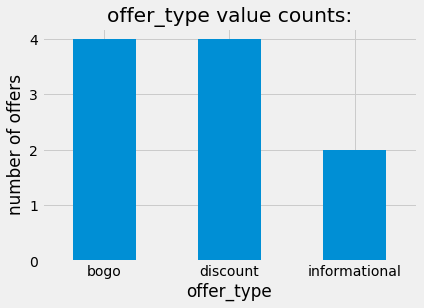

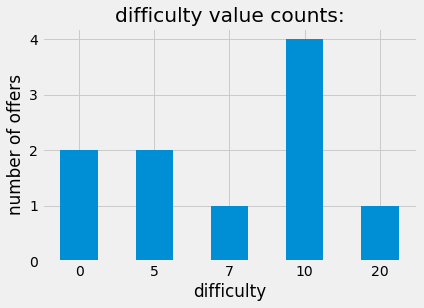

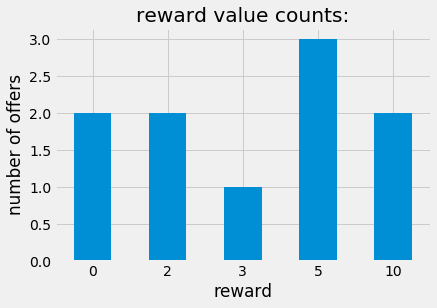

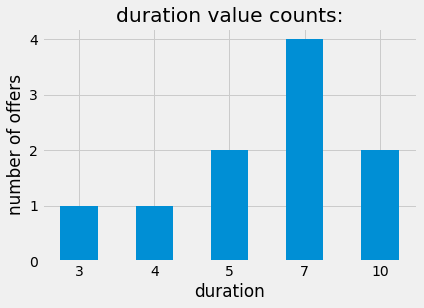

In [258]:
# How many of each offer type do we have? 

cols = ['offer_type', 'difficulty', 'reward', 'duration']

for col in cols:
    portfolio[col].value_counts().sort_index().plot.bar(title=col + " value counts:")
    plt.xlabel(col)
    plt.xticks(rotation=0)
    plt.ylabel('number of offers')
    plt.show()


#### Portfolio DataFrame Takeaways

1. There are 10 different offers - 2 informational, 4 bogo, 4
2. The offer difficulties range from \\$0 \(for informational offers\) to \\$20, the most common being \\$10.
3. The offer rewards range from \\$0 \(for informational offers to\) \\$10, the most common being \\$5.
4. The offer durations range from 3 days to 10 days, the most common being 7 days.

### Profile DataFrame Understanding

In [270]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


I'm noticing there are a lot of 118 values

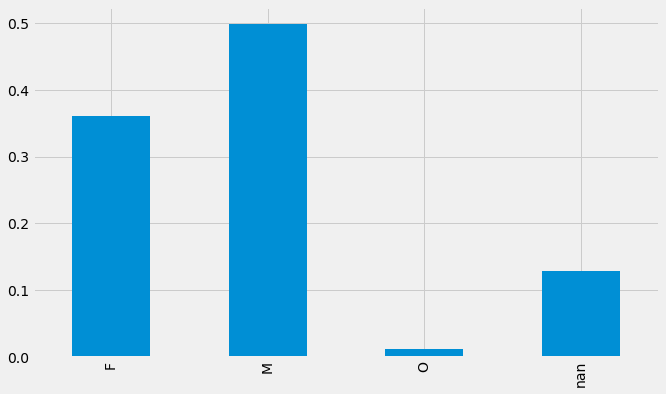

In [260]:
profile['gender'].value_counts(dropna=False, normalize=True).sort_index().plot.bar(figsize=(10,6))

In [286]:
def plot_hist(df, col, bins, bin_size, x_range):
    """plots a histogram for a given column
    INPUTS
    df: df
    col (str): column in df
    bins (int): number of bins
    x_range (tup): range of x_values
    OUTPUTS
    histogram
    """
    profile[col].plot.hist(figsize=(10,6), bins=bins, range=x_range, alpha=0.8)
    plt.xticks(ticks=np.arange(x_range[0], x_range[1], bin_size))
    plt.xlabel(col)
    plt.show()
    

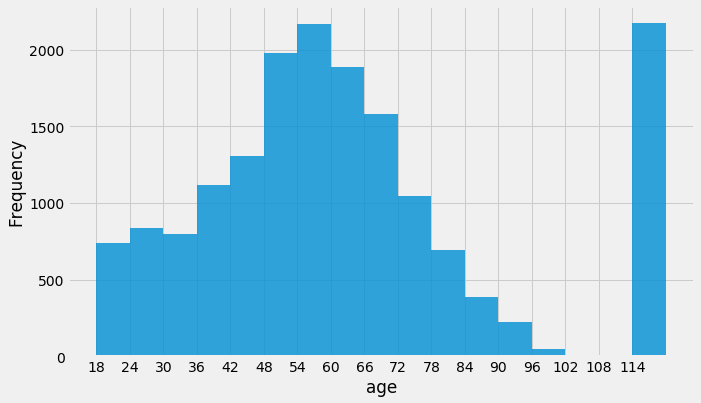

In [287]:
plot_hist(df=profile, col='age', bins=17, bin_size=6, x_range=(18,120))

Text(0.5, 0, 'age')

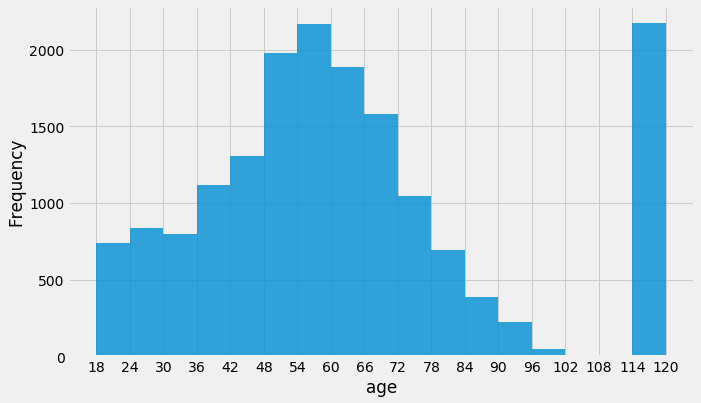

In [280]:
profile['age'].plot.hist(figsize=(10,6), bins=17, range=(18,120), alpha=0.8)
plt.xticks(ticks=np.arange(18,121, 6))
plt.xlabel('age')

In [226]:


print('portfolio_null_values:\n', portfolio.isnull().sum())
print('\nprofile_null_values:\n', profile.isnull().sum())
print('\ntranscript_null_values\n', transcript.isnull().sum())

portfolio_null_values:
 reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

profile_null_values:
 gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

transcript_null_values
 person    0
event     0
value     0
time      0
dtype: int64


It appears only the profile dataframe has null values. We will handle these later.

In [166]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [167]:
def clean_portfolio(df=portfolio):
    # Create an ID column that is more readable than the id hash
    df['readable_id'] = ['BOGO - $10 - 7days', 'BOGO - $10 - 5days', 'INFO - $0 - 4days', 'BOGO - $5 - 7days',
                           'DISC - \$20/\$5 - 10days', 'DISC - $7/$3 - 7days', 'DISC - \$10/\$2 - 10days', 'INFO - $0 - 3days',
                           'BOGO - $5 - 5days', 'DISC - \$10/\$2 - 7days']
    
    # Extract channels into their own columns one-hot encoded
    df['email'] = df['channels'].apply(lambda x: 1 if 'email' in x else 0)
    df['mobile'] = df['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    df['social'] = df['channels'].apply(lambda x: 1 if 'social' in x else 0)
    df['web'] = df['channels'].apply(lambda x: 1 if 'web' in x else 0)
    
    # Drop unneeded columns
    df.drop(columns=['channels'], inplace=True, errors='ignore')
    
    # Turn offer_type into a dummy variable
    df = pd.get_dummies(df, columns=['offer_type'])
    
    # Rename dummy columns
    df.rename(columns={'offer_type_bogo':'bogo', 'offer_type_discount':'discount', 'offer_type_informational':'informational'}, inplace=True)
    df = df[['readable_id', 'id', 'difficulty', 'reward', 'duration', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational']]
    

    return df

clean_portfolio = clean_portfolio(df=portfolio)
clean_portfolio.to_csv('clean_portfolio.csv', index=False)


In [168]:
clean_portfolio.head()

,readable_id,id,difficulty,reward,duration,email,mobile,social,web,bogo,discount,informational
0,BOGO - $10 - 7days,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
1,BOGO - $10 - 5days,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
2,INFO - $0 - 4days,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
3,BOGO - $5 - 7days,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
4,DISC - \$20/\$5 - 10days,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,10,1,0,0,1,0,1,0


In [169]:
def clean_profile(df=profile):
    
    # Convert column to datetime object
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    
    # Extract the year 
    df['member_year'] = pd.DatetimeIndex(df['became_member_on']).year
    
    # Change 118 to nan. This was likely used as a placeholder to indicate unknown.
    # Customers with this age also had null values for income and gender
    df.loc[df['age'] == 118] = np.nan
    
    # Drop nulls - We do not have any demographic information regarding these customers to work with
    df = df.dropna(axis=0)
    
    # create age groups 
    cond_lst = [df['age'].between(18,24),
            df['age'].between(25,34),
            df['age'].between(35,44),
            df['age'].between(45,54),
            df['age'].between(55,64),
            df['age'].between(65,117),
            df['age'] == 118]
    choice_lst = ["18-24", "25-34", "35-44", "45-54", "55-64", "65+", "Unknown"]
    df['age_group'] = np.select(condlist = cond_lst, choicelist=choice_lst)
    

    cond_lst = [df['income'].between(30000,44999),
                df['income'].between(45000,59999),
                df['income'].between(60000,74999),
                df['income'].between(75000,89999),
                df['income'].between(90000,104999),
                df['income'].between(105000,120000),
                df['income'].isnull()]
    choice_lst = ["30-45k", "45-60k", "60-75k", "75-90k", "90-105k", "105k+", 'Unknown']

    df['income_group'] = np.select(condlist = cond_lst, choicelist=choice_lst)    
    
    
    return df

clean_profile = clean_profile(df=profile)
clean_profile.to_csv('clean_profile.csv',index=False)

/Users/jordannishimura/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jordannishimura/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [170]:
clean_profile

,gender,age,id,became_member_on,income,member_year,age_group,income_group
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017.0,55-64,105k+
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017.0,65+,90-105k
5,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018.0,65+,60-75k
8,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018.0,65+,45-60k
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017.0,55-64,45-60k
...,...,...,...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018.0,45-54,45-60k
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018.0,55-64,60-75k
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017.0,45-54,60-75k
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016.0,65+,45-60k


In [171]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [172]:
def clean_transcript(df=transcript):
    df['transaction_amt'] = df.apply(lambda row: row['value']['amount'] if 'amount' in row['value'].keys() else np.nan, axis=1)
    df['offer_id'] = df.apply(lambda row: row['value']['offer id'] if 'offer id' in row['value'].keys() else np.nan, axis=1)
    df['reward'] = df.apply(lambda row: row['value']['reward'] if 'reward' in row['value'].keys() else np.nan, axis=1)
    
    df.drop(columns=['value'], inplace=True, errors='ignore')
    
    return df

clean_transcript = clean_transcript(df=transcript)
clean_transcript

,person,event,time,transaction_amt,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN


In [173]:
clean_transcript.to_csv('clean_transcript.csv', index=False)

portfolio shape:  (10, 6) 
profile shape:  (17000, 5) 
transcript shape:  (306534, 4)


In [72]:
profile.isnull().mean()

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

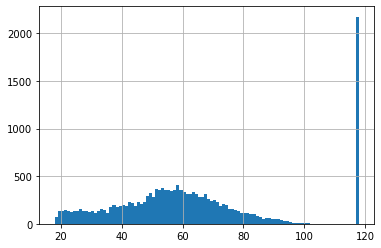

In [73]:
profile['age'].hist(bins=100)

In [74]:
profile.loc[profile['age'] == 118, 'age'] = np.nan
profile.isnull().sum()

gender              2175
age                 2175
id                     0
became_member_on       0
income              2175
dtype: int64

In [174]:
clean_transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [178]:
clean_profile

,gender,age,id,became_member_on,income,member_year,age_group,income_group
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017.0,55-64,105k+
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017.0,65+,90-105k
5,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018.0,65+,60-75k
8,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018.0,65+,45-60k
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017.0,55-64,45-60k
...,...,...,...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018.0,45-54,45-60k
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018.0,55-64,60-75k
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017.0,45-54,60-75k
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016.0,65+,45-60k


In [185]:
def create_master_df(portfolio_df=clean_portfolio, profile_df=clean_profile, transcript_df=clean_transcript):
    """Merges the three datasets to one master df
    INPUTS
    portfolio_df: dataframe of offers including and 'offer_id' column with offer id's
    profile_df: dataframe of customer demographic data including an 'id' column with customer id's
    transcript_df: dataframe of every event during experiment including offer_id column and customer_id column
    
    OUTPUTS
    master_df: a dataframe of every event during experiment with demographic data
    """
    
    # merge transcript_df and profile_df on customer id
    df = pd.merge(transcript_df, profile_df, how='left', left_on='person', right_on='id')
    
    # drop 'id' column because this is the same as the 'person' column
    df.drop(columns=['id'], inplace=True)
    
    # merge above df with portfolio_df to include information about offers
    master_df = pd.merge(df, portfolio_df, how='left', left_on='offer_id', right_on='id')
    
    # drop reward_x column, as we only need the reward in the offer_received events and drop 'id' as this is the same as 'offer_id'
    master_df.drop(columns=['reward_x', 'id'], inplace=True)
    
    
    return master_df
    
create_master_df()

,person,event,time,transaction_amt,offer_id,gender,age,became_member_on,income,member_year,age_group,income_group,readable_id,difficulty,reward_y,duration,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017-05-09,100000.0,2017.0,65+,90-105k,BOGO - $5 - 7days,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaT,NaN,NaN,NaN,NaN,DISC - \$20/\$5 - 10days,20.0,5.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,M,68.0,2018-04-26,70000.0,2018.0,65+,60-75k,DISC - \$10/\$2 - 7days,10.0,2.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaT,NaN,NaN,NaN,NaN,DISC - \$10/\$2 - 10days,10.0,2.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,BOGO - $10 - 5days,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,M,66.0,2018-01-01,47000.0,2018.0,65+,45-60k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,M,52.0,2018-04-08,62000.0,2018.0,45-54,60-75k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,F,63.0,2013-09-22,52000.0,2013.0,55-64,45-60k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,M,57.0,2016-07-09,40000.0,2016.0,55-64,30-45k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
clean_portfolio

,readable_id,id,difficulty,reward,duration,email,mobile,social,web,bogo,discount,informational
0,BOGO - $10 - 7days,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
1,BOGO - $10 - 5days,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
2,INFO - $0 - 4days,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
3,BOGO - $5 - 7days,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
4,DISC - \$20/\$5 - 10days,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,10,1,0,0,1,0,1,0
5,DISC - $7/$3 - 7days,2298d6c36e964ae4a3e7e9706d1fb8c2,7,3,7,1,1,1,1,0,1,0
6,DISC - \$10/\$2 - 10days,fafdcd668e3743c1bb461111dcafc2a4,10,2,10,1,1,1,1,0,1,0
7,INFO - $0 - 3days,5a8bc65990b245e5a138643cd4eb9837,0,0,3,1,1,1,0,0,0,1
8,BOGO - $5 - 5days,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,DISC - \$10/\$2 - 7days,2906b810c7d4411798c6938adc9daaa5,10,2,7,1,1,0,1,0,1,0


In [86]:
df = pd.merge(transcript, profile, how='left', left_on = 'person', right_on='id')
df.head()

,person,event,time,transaction_amt,offer_id,reward,gender,age,id,became_member_on,income,became_member_year,age_group,income_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,65+,90-105k
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,0,Unknown
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,65+,60-75k
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017,0,Unknown
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,NaN,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017,0,Unknown


In [87]:
df = df.drop(columns='id')
df.head()

,person,event,time,transaction_amt,offer_id,reward,gender,age,became_member_on,income,became_member_year,age_group,income_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,2017-05-09,100000.0,2017,65+,90-105k
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,NaN,2017-08-04,NaN,2017,0,Unknown
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,M,68.0,2018-04-26,70000.0,2018,65+,60-75k
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,NaN,2017-09-25,NaN,2017,0,Unknown
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,NaN,2017-10-02,NaN,2017,0,Unknown


In [88]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [90]:
df = pd.merge(df, portfolio, how='left', left_on='offer_id', right_on='id')

df

,person,event,time,transaction_amt,offer_id,reward_x,gender,age,became_member_on,income,became_member_year,age_group,income_group,reward_y,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,2017-05-09,100000.0,2017,65+,90-105k,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,NaN,2017-08-04,NaN,2017,0,Unknown,5.0,"[web, email]",20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,M,68.0,2018-04-26,70000.0,2018,65+,60-75k,2.0,"[web, email, mobile]",10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,NaN,2017-09-25,NaN,2017,0,Unknown,2.0,"[web, email, mobile, social]",10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,NaN,2017-10-02,NaN,2017,0,Unknown,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN,M,66.0,2018-01-01,47000.0,2018,65+,45-60k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN,M,52.0,2018-04-08,62000.0,2018,45-54,60-75k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN,F,63.0,2013-09-22,52000.0,2013,55-64,45-60k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN,M,57.0,2016-07-09,40000.0,2016,55-64,30-45k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# essentially merge the reward_x and reward_y columns, as they describe the same thing. reward_x is when the event is "offer completed". reward_y occurs from "offer viewed" or "offer received"

df.loc[df['reward_x'].isnull(), 'reward_x'] = df['reward_y']
df.loc[df['reward_y'].isnull(), 'reward_y'] = df['reward_x']

In [92]:
df = df.drop(columns = ['id', 'channels', 'reward_y'], errors='ignore')
df

,person,event,time,transaction_amt,offer_id,reward_x,gender,age,became_member_on,income,became_member_year,age_group,income_group,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,F,75.0,2017-05-09,100000.0,2017,65+,90-105k,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,None,NaN,2017-08-04,NaN,2017,0,Unknown,20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,M,68.0,2018-04-26,70000.0,2018,65+,60-75k,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,None,NaN,2017-09-25,NaN,2017,0,Unknown,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,None,NaN,2017-10-02,NaN,2017,0,Unknown,10.0,5.0,bogo,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN,M,66.0,2018-01-01,47000.0,2018,65+,45-60k,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN,M,52.0,2018-04-08,62000.0,2018,45-54,60-75k,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN,F,63.0,2013-09-22,52000.0,2013,55-64,45-60k,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN,M,57.0,2016-07-09,40000.0,2016,55-64,30-45k,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
df['offer_active_until'] = df.apply(lambda row: row['duration'] * 24 + row['time'] if row['event'] == 'offer received' else np.nan, axis=1)

df

,person,event,time,transaction_amt,offer_id,reward_x,gender,age,became_member_on,income,became_member_year,age_group,income_group,difficulty,duration,offer_type,email,mobile,social,web,offer_active_until
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,F,75.0,2017-05-09,100000.0,2017,65+,90-105k,5.0,7.0,bogo,1.0,1.0,0.0,1.0,168.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,None,NaN,2017-08-04,NaN,2017,0,Unknown,20.0,10.0,discount,1.0,0.0,0.0,1.0,240.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,M,68.0,2018-04-26,70000.0,2018,65+,60-75k,10.0,7.0,discount,1.0,1.0,0.0,1.0,168.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,None,NaN,2017-09-25,NaN,2017,0,Unknown,10.0,10.0,discount,1.0,1.0,1.0,1.0,240.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,None,NaN,2017-10-02,NaN,2017,0,Unknown,10.0,5.0,bogo,1.0,1.0,1.0,1.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN,M,66.0,2018-01-01,47000.0,2018,65+,45-60k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN,M,52.0,2018-04-08,62000.0,2018,45-54,60-75k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN,F,63.0,2013-09-22,52000.0,2013,55-64,45-60k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN,M,57.0,2016-07-09,40000.0,2016,55-64,30-45k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
test = df.loc[df['person'] == '1e9420836d554513ab90eba98552d0a9']
test

,person,event,time,transaction_amt,offer_id,reward_x,gender,age,became_member_on,income,became_member_year,age_group,income_group,difficulty,duration,offer_type,email,mobile,social,web,offer_active_until
19,1e9420836d554513ab90eba98552d0a9,offer received,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,M,22.0,2017-09-25,70000.0,2017,18-24,60-75k,10.0,7.0,bogo,1.0,1.0,1.0,0.0,168.0
40779,1e9420836d554513ab90eba98552d0a9,offer viewed,96,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,M,22.0,2017-09-25,70000.0,2017,18-24,60-75k,10.0,7.0,bogo,1.0,1.0,1.0,0.0,NaN
53196,1e9420836d554513ab90eba98552d0a9,offer received,168,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,M,22.0,2017-09-25,70000.0,2017,18-24,60-75k,10.0,5.0,bogo,1.0,1.0,1.0,1.0,288.0
69328,1e9420836d554513ab90eba98552d0a9,offer viewed,174,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,M,22.0,2017-09-25,70000.0,2017,18-24,60-75k,10.0,5.0,bogo,1.0,1.0,1.0,1.0,NaN
79426,1e9420836d554513ab90eba98552d0a9,transaction,198,17.11,NaN,NaN,M,22.0,2017-09-25,70000.0,2017,18-24,60-75k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79427,1e9420836d554513ab90eba98552d0a9,offer completed,198,NaN,NaN,10.0,M,22.0,2017-09-25,70000.0,2017,18-24,60-75k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95104,1e9420836d554513ab90eba98552d0a9,transaction,252,18.82,NaN,NaN,M,22.0,2017-09-25,70000.0,2017,18-24,60-75k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110847,1e9420836d554513ab90eba98552d0a9,offer received,336,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,M,22.0,2017-09-25,70000.0,2017,18-24,60-75k,10.0,5.0,bogo,1.0,1.0,1.0,1.0,456.0
132808,1e9420836d554513ab90eba98552d0a9,offer viewed,354,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,M,22.0,2017-09-25,70000.0,2017,18-24,60-75k,10.0,5.0,bogo,1.0,1.0,1.0,1.0,NaN
137420,1e9420836d554513ab90eba98552d0a9,transaction,366,9.57,NaN,NaN,M,22.0,2017-09-25,70000.0,2017,18-24,60-75k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
offers = test.loc[test['event'] == 'offer received']

print(test.loc[(test['time'].between(0,168)) & (test['event'] == 'transaction'), 'transaction_amt'].sum())

df['amt_spent_under_offer'] = 0
df['offer_completed'] = 0
df['offer_viewed'] = 0


start = offers['time'].iloc[1]
end = offers['offer_active_until'].iloc[1]

print(start, end)

0.0
168 288.0


In [43]:
# iterate through each customer
num_customers = df['person'].unique().shape[0]

for person in tqdm(df['person'].unique(), desc='Progress'):
    # create a dataframe of only 1 person's events
    customer_data = df.loc[df['person'] == person]

    # create a dataframe of only offer received events
    customer_offers = customer_data.loc[customer_data['event'] == 'offer received']

    # dataframe of only offer viewed events
    customer_viewed_offers = customer_data.loc[customer_data['event'] == 'offer viewed']

    # dataframe of offer completed events 
    customer_completed_offers = customer_data.loc[customer_data['event'] == 'offer completed']


    # iterate through the customers received offers
    for idx, offer in customer_offers.iterrows():

        offer_start = offer['time']
        offer_end = offer['offer_active_until']
        offer_id = offer['offer_id']

        amt_spent = customer_data.loc[(customer_data['time'].between(offer_start, offer_end)) 
                                      & (customer_data['event'] == 'transaction'), 'transaction_amt'].sum()

        df.loc[idx, 'amt_spent_under_offer'] = amt_spent

        offer_completed_times = np.array(customer_completed_offers['time'])

        for idx1, completed in customer_completed_offers.iterrows():
            if (offer_start <= completed['time']) and (completed['time'] <= offer_end):
                df.loc[idx, 'offer_completed'] = 1
                break

        offer_viewed_times = np.array(customer_viewed_offers['time'])

        for idx2, view in customer_viewed_offers.iterrows():
            if (offer_start <= view['time']) and (view['time'] <= offer_end) and (view['offer_id'] == offer_id):
                df.loc[idx, 'offer_viewed'] = 1
                break        




Progress: 100%|██████████| 17000/17000 [32:48<00:00,  8.63it/s]


In [45]:
df['offer_completed_check'] = (df['amt_spent_under_offer'] > df['difficulty']).astype(int)

In [46]:
df.loc[df['person']=='78afa995795e4d85b5d9ceeca43f5fef'][['person', 'event', 'time', 'offer_active_until', 'offer_type', 'offer_id',
                                                        'transaction_amt', 'difficulty', 
                                                          'amt_spent_under_offer', 'offer_viewed', 'offer_completed']]

,person,event,time,offer_active_until,offer_type,offer_id,transaction_amt,difficulty,amt_spent_under_offer,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,168.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,37.67,1,1
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,0.00,0,0
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,NaN,NaN,NaN,19.89,NaN,0.00,0,0
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,NaN,NaN,NaN,NaN,0.00,0,0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,NaN,NaN,NaN,17.78,NaN,0.00,0,0
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,240.0,informational,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,49.39,1,0
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,NaN,informational,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,0.00,0,0
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,NaN,NaN,NaN,19.67,NaN,0.00,0,0
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,NaN,NaN,NaN,29.72,NaN,0.00,0,0
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,NaN,NaN,NaN,23.93,NaN,0.00,0,0


In [47]:
df.to_csv('starbucks_master_clean.csv', index=False)

In [3]:
master_df = pd.read_csv('starbucks_master_clean.csv')
master_df

,person,event,time,transaction_amt,offer_id,reward_x,gender,age,became_member_on,income,...,offer_type,email,mobile,social,web,offer_active_until,amt_spent_under_offer,offer_completed,offer_viewed,offer_completed_check
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,F,75.0,2017-05-09,100000.0,...,bogo,1.0,1.0,0.0,1.0,168.0,37.67,1,1,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,NaN,NaN,2017-08-04,NaN,...,discount,1.0,0.0,0.0,1.0,240.0,1.09,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,M,68.0,2018-04-26,70000.0,...,discount,1.0,1.0,0.0,1.0,168.0,0.00,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,NaN,2017-09-25,NaN,...,discount,1.0,1.0,1.0,1.0,240.0,0.00,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,NaN,NaN,2017-10-02,NaN,...,bogo,1.0,1.0,1.0,1.0,120.0,0.00,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN,M,66.0,2018-01-01,47000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,0,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN,M,52.0,2018-04-08,62000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,0,0
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN,F,63.0,2013-09-22,52000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,0,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN,M,57.0,2016-07-09,40000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,0,0


In [4]:
master_df['offer_successful'] = ((master_df['offer_viewed'] + master_df['offer_completed']) == 2).astype(int)
master_df

,person,event,time,transaction_amt,offer_id,reward_x,gender,age,became_member_on,income,...,email,mobile,social,web,offer_active_until,amt_spent_under_offer,offer_completed,offer_viewed,offer_completed_check,offer_successful
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,F,75.0,2017-05-09,100000.0,...,1.0,1.0,0.0,1.0,168.0,37.67,1,1,1,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,NaN,NaN,2017-08-04,NaN,...,1.0,0.0,0.0,1.0,240.0,1.09,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,M,68.0,2018-04-26,70000.0,...,1.0,1.0,0.0,1.0,168.0,0.00,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,NaN,2017-09-25,NaN,...,1.0,1.0,1.0,1.0,240.0,0.00,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,NaN,NaN,2017-10-02,NaN,...,1.0,1.0,1.0,1.0,120.0,0.00,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN,M,66.0,2018-01-01,47000.0,...,NaN,NaN,NaN,NaN,NaN,0.00,0,0,0,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN,M,52.0,2018-04-08,62000.0,...,NaN,NaN,NaN,NaN,NaN,0.00,0,0,0,0
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN,F,63.0,2013-09-22,52000.0,...,NaN,NaN,NaN,NaN,NaN,0.00,0,0,0,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN,M,57.0,2016-07-09,40000.0,...,NaN,NaN,NaN,NaN,NaN,0.00,0,0,0,0


In [11]:
num_offers_received = master_df.loc[master_df['event'] == 'offer received'].shape[0]
num_offers_viewed = master_df['offer_viewed'].sum()

# completed offers may have been viewed or not
num_offers_completed = master_df['offer_completed'].sum()

# A successful offer is one that was viewed and completed
num_offers_successful = master_df['offer_successful'].sum()

print('num_offers_received: ', num_offers_received)
print('num_offers_viewed: ', num_offers_viewed)
print('num_offers_completed: ', num_offers_completed)
print('num_offers_successful: ', num_offers_successful)

num_offers_received:  76277
num_offers_viewed:  56895
num_offers_completed:  36172
num_offers_successful:  29550


In [8]:
master_df['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [16]:
master_df.loc[(master_df['event'] == 'offer received') & (master_df['offer_completed'] == 1) & (master_df['offer_completed_check'] == 0)].sort_values('person')

master_df.loc[master_df['person'] == 'fe3f369d2f49407caf10c1e193043760'][['event', 'offer_id', 'time', 
                                                                   'offer_active_until',
                                                                   'transaction_amt', 'difficulty',
                                                                   'amt_spent_under_offer', 
                                                                   'offer_completed', 
                                                                   'offer_viewed', 'offer_completed_check', 
                                                                   'offer_successful']]

,event,offer_id,time,offer_active_until,transaction_amt,difficulty,amt_spent_under_offer,offer_completed,offer_viewed,offer_completed_check,offer_successful
10437,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,168.0,NaN,5.0,2.60,0,0,0,0
19917,transaction,NaN,12,NaN,2.60,NaN,0.00,0,0,0,0
63645,offer received,fafdcd668e3743c1bb461111dcafc2a4,168,408.0,NaN,10.0,23.53,1,1,1,1
71670,transaction,NaN,174,NaN,2.79,NaN,0.00,0,0,0,0
84987,offer viewed,fafdcd668e3743c1bb461111dcafc2a4,210,NaN,NaN,10.0,0.00,0,0,0,0
91872,transaction,NaN,234,NaN,4.86,NaN,0.00,0,0,0,0
101269,transaction,NaN,276,NaN,6.58,NaN,0.00,0,0,0,0
101270,offer completed,NaN,276,NaN,NaN,NaN,0.00,0,0,0,0
106793,transaction,NaN,306,NaN,1.39,NaN,0.00,0,0,0,0
110668,transaction,NaN,330,NaN,4.72,NaN,0.00,0,0,0,0


In [20]:
master_df = master_df[master_df['event'] == 'offer received']
master_df

,person,event,time,transaction_amt,offer_id,reward_x,gender,age,became_member_on,income,...,email,mobile,social,web,offer_active_until,amt_spent_under_offer,offer_completed,offer_viewed,offer_completed_check,offer_successful
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,F,75.0,2017-05-09,100000.0,...,1.0,1.0,0.0,1.0,168.0,37.67,1,1,1,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,NaN,NaN,2017-08-04,NaN,...,1.0,0.0,0.0,1.0,240.0,1.09,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,M,68.0,2018-04-26,70000.0,...,1.0,1.0,0.0,1.0,168.0,0.00,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,NaN,2017-09-25,NaN,...,1.0,1.0,1.0,1.0,240.0,0.00,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,NaN,NaN,2017-10-02,NaN,...,1.0,1.0,1.0,1.0,120.0,0.00,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,576,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,M,56.0,2016-10-23,51000.0,...,1.0,1.0,1.0,0.0,744.0,35.55,1,1,1,1
257883,cb23b66c56f64b109d673d5e56574529,offer received,576,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,M,60.0,2018-05-05,113000.0,...,1.0,1.0,0.0,1.0,744.0,0.00,0,0,0,0
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,576,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,F,45.0,2018-06-04,54000.0,...,1.0,1.0,1.0,1.0,744.0,6.76,0,1,0,0
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,576,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,F,83.0,2016-03-07,50000.0,...,1.0,1.0,1.0,0.0,744.0,58.50,1,1,1,1


,person,event,time,transaction_amt,offer_id,reward_x,gender,age,became_member_on,income,...,email,mobile,social,web,offer_active_until,amt_spent_under_offer,offer_completed,offer_viewed,offer_completed_check,offer_successful
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,M,68.0,2018-04-26,70000.0,...,1.0,1.0,0.0,1.0,168.0,0.00,0,1,0,0
110830,e2127556f4f64592b11af22de27a7932,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,0.0,M,68.0,2018-04-26,70000.0,...,1.0,1.0,0.0,1.0,432.0,0.00,0,0,0,0
150600,e2127556f4f64592b11af22de27a7932,offer received,408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,M,68.0,2018-04-26,70000.0,...,1.0,1.0,0.0,1.0,576.0,18.42,1,1,1,1
201574,e2127556f4f64592b11af22de27a7932,offer received,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,M,68.0,2018-04-26,70000.0,...,1.0,1.0,1.0,1.0,744.0,18.42,1,1,1,1


In [48]:
master_df['num_offers_received'] = 0
master_df['num_specific_offer_id_received'] = 0

In [50]:
for person in tqdm(master_df['person'].unique(), desc='Progress'):
    total_num_offers_customer = master_df.loc[master_df['person'] == person].shape[0]
    master_df.loc[master_df['person'] == person, 'num_offers_received'] = np.arange(0, total_num_offers_customer)
    for offer_id in master_df.loc[master_df['person'] == person, 'offer_id'].unique():
        num_offers = master_df.loc[(master_df['person'] == person) & (master_df['offer_id'] == offer_id)].shape[0]
        master_df.loc[(master_df['person'] == person) & (master_df['offer_id'] == offer_id), 'num_specific_offer_id_received'] = np.arange(0, num_offers)


Progress: 100%|██████████| 16994/16994 [38:18<00:00,  7.39it/s] 


In [59]:
master_df.groupby('person')['offer_id'].size().sort_values()

person
8cded7272788493a8e71cf419722b66a    1
22617705eec442e0b7b43e5c5f56fb17    1
fecbf0774931488781713494b726a121    1
2dd5daa8a5e14fcd8fca67457541fc48    1
9acbb111ba2f452cbbafabaf49138377    1
                                   ..
d86d562ac40c482194fcd54999f82148    6
3cabd0099961416b9810043e7eb0f743    6
aedf8121e1e24dd7ba239ed18479f54c    6
3bc7544c64164046a017fa6c20d65a6c    6
ffff82501cea40309d5fdd7edcca4a07    6
Name: offer_id, Length: 16994, dtype: int64

In [60]:
master_df[master_df['person'] == 'ffff82501cea40309d5fdd7edcca4a07']

,person,event,time,transaction_amt,offer_id,reward_x,gender,age,became_member_on,income,...,social,web,offer_active_until,amt_spent_under_offer,offer_completed,offer_viewed,offer_completed_check,offer_successful,num_offers_received,num_specific_offer_id_received
1393,ffff82501cea40309d5fdd7edcca4a07,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,F,45.0,2016-11-25,62000.0,...,1.0,1.0,240.0,88.55,1,1,1,1,0,0
54574,ffff82501cea40309d5fdd7edcca4a07,offer received,168,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,F,45.0,2016-11-25,62000.0,...,0.0,1.0,408.0,111.94,1,1,1,1,1,0
112214,ffff82501cea40309d5fdd7edcca4a07,offer received,336,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,F,45.0,2016-11-25,62000.0,...,0.0,1.0,504.0,54.08,1,1,1,1,2,0
152030,ffff82501cea40309d5fdd7edcca4a07,offer received,408,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,F,45.0,2016-11-25,62000.0,...,0.0,1.0,576.0,52.74,1,1,1,1,3,1
202962,ffff82501cea40309d5fdd7edcca4a07,offer received,504,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,F,45.0,2016-11-25,62000.0,...,0.0,1.0,672.0,51.05,1,1,1,1,4,0
246495,ffff82501cea40309d5fdd7edcca4a07,offer received,576,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,F,45.0,2016-11-25,62000.0,...,0.0,1.0,744.0,43.26,1,1,1,1,5,2


In [47]:
master_df

,person,event,time,transaction_amt,offer_id,reward_x,gender,age,became_member_on,income,...,mobile,social,web,offer_active_until,amt_spent_under_offer,offer_completed,offer_viewed,offer_completed_check,offer_successful,num_offers_received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,F,75.0,2017-05-09,100000.0,...,1.0,0.0,1.0,168.0,37.67,1,1,1,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,NaN,NaN,2017-08-04,NaN,...,0.0,0.0,1.0,240.0,1.09,0,1,0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,M,68.0,2018-04-26,70000.0,...,1.0,0.0,1.0,168.0,0.00,0,1,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,NaN,2017-09-25,NaN,...,1.0,1.0,1.0,240.0,0.00,0,1,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,NaN,NaN,2017-10-02,NaN,...,1.0,1.0,1.0,120.0,0.00,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,576,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,M,56.0,2016-10-23,51000.0,...,1.0,1.0,0.0,744.0,35.55,1,1,1,1,5
257883,cb23b66c56f64b109d673d5e56574529,offer received,576,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,M,60.0,2018-05-05,113000.0,...,1.0,0.0,1.0,744.0,0.00,0,0,0,0,2
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,576,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,F,45.0,2018-06-04,54000.0,...,1.0,1.0,1.0,744.0,6.76,0,1,0,0,2
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,576,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,F,83.0,2016-03-07,50000.0,...,1.0,1.0,0.0,744.0,58.50,1,1,1,1,2


###  Exploratory Analysis
1. Demographic Data
2. Transaction Data
3. Offers Data

In [473]:
plt.style.use('fivethirtyeight')

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Num Customers')

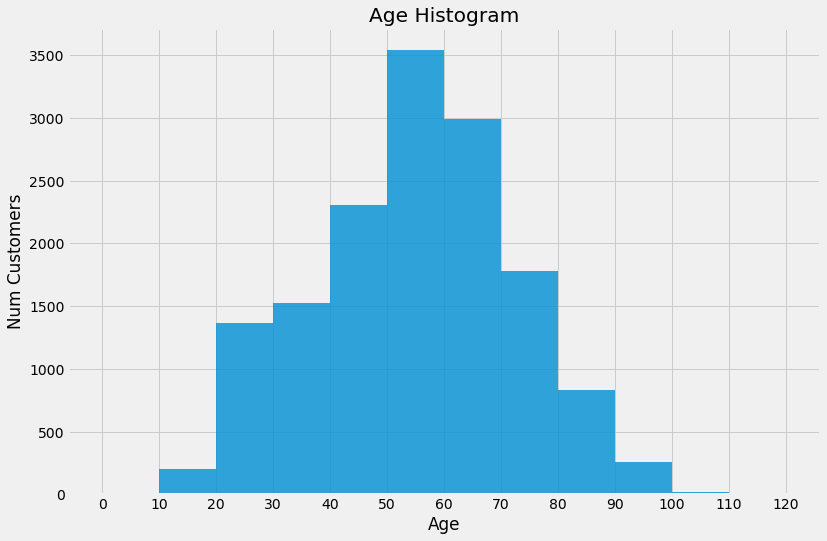

In [481]:
fig, ax = plt.subplots(figsize=(12,8));
x = profile['age'];
ax.hist(x, bins=12, range=(0,120), align='mid', alpha=0.8);
ax.set_xticks(range(0,121,10))
ax.set_title('Age Histogram')
ax.set_xlabel('Age')
ax.set_ylabel('Num Customers')

In [475]:
[str(x)[:-5] + 'k' for x in np.linspace(30000, 120000, 10)]



['30k', '40k', '50k', '60k', '70k', '80k', '90k', '100k', '110k', '120k']

Text(0, 0.5, 'Num Customers')

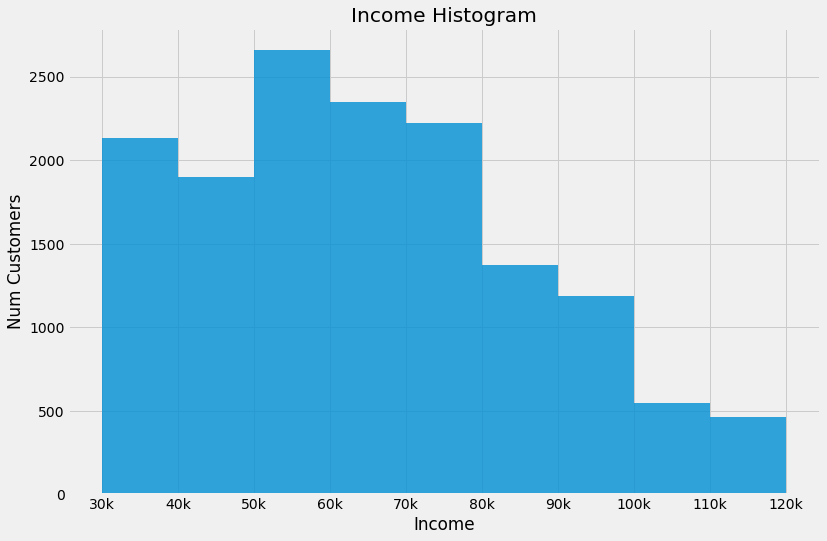

In [482]:
fig, ax = plt.subplots(figsize=(12,8));
x = profile['income'];
ax.hist(x, bins=9, range=(30000,120001), align='mid', alpha=0.8);
ax.set_xticks(np.linspace(30000, 120000, 10))
ax.set_xticklabels([str(x)[:-5] + 'k' for x in np.linspace(30000, 120000, 10)])
ax.set_title('Income Histogram')
ax.set_xlabel('Income')
ax.set_ylabel('Num Customers')


[Text(0, 0.0, '0%'),
 Text(0, 0.09999999999999999, '10%'),
 Text(0, 0.19999999999999998, '20%'),
 Text(0, 0.3, '30%'),
 Text(0, 0.39999999999999997, '40%'),
 Text(0, 0.49999999999999994, '50%'),
 Text(0, 0.6, '60%')]

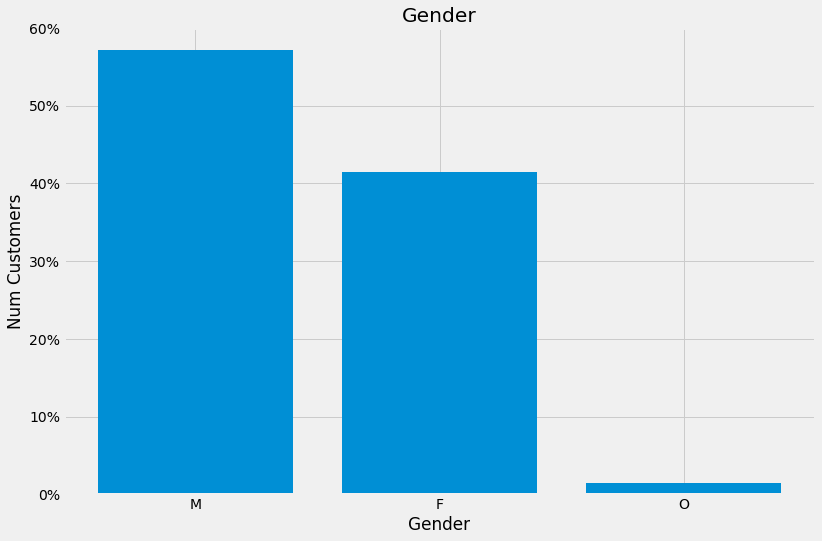

In [477]:
fig, ax = plt.subplots(figsize=(12,8))

data = df['gender'].value_counts(normalize=True).reset_index()
x = data['index'].tolist()
height = data['gender']

ax.bar(x=data['index'].tolist(), height=data['gender'].tolist())
ax.set_title('Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Num Customers')
ax.set_yticks(np.linspace(0,0.6,7))
ax.set_yticklabels("{:.0f}%".format(x) for x in np.linspace(0, 60, 7))

In [478]:
med_age = df['age'].median()
mean_age = df['age'].mean()

med_income = df['income'].median()
mean_income = df['income'].mean()

print("The median age is {}. The mean age is {:.1f}.".format(med_age, mean_age))
print("The median income is {}. The mean income is {:.1f}.".format(med_income, mean_income))

The median age is 55.0. The mean age is 53.8.
The median income is 62000.0. The mean income is 64337.0.


In [479]:
df['gender'].value_counts(normalize=True)

M    0.570791
F    0.414651
O    0.014558
Name: gender, dtype: float64

### Takeaways
The most common age group for starbucks customers is 50-59. The least common is 10-19 and 90-99. 
It appears they used 118 to mean the customers age is unknown, as there are 33772 instances of that age.

The most common income group is 50k to 60k, and the least common is 100k and above. 

There are more male customers (57%) than female customers (41%).

In [69]:
df[df['transaction_amt'] > 1000]

NameError: name 'df' is not defined

NameError: name 'df' is not defined

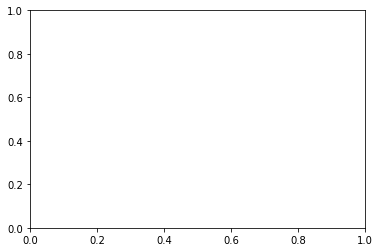

In [62]:
fig, ax = plt.subplots()

ax.hist(df['transaction_amt'], range=(0,50))
        

1. Frequency of transactions by gender, age, and income
2. Average Transaction amount by gender, age, and income
3. Total Spent in Experimeny by gender, age, and income

In [223]:
transactions = df.loc[df['event'] == 'transaction']
transactions.head()

,person,event,time,age,became_member_on,income,transaction_amt,offer_id,reward_received,channels,difficulty,duration,email,mobile,social,web,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,20,2016-07-11,30000.0,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,42,2016-01-17,96000.0,34.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0
12659,54890f68699049c2a04d415abc25e717,transaction,0,36,2017-12-28,56000.0,13.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,55,2017-10-16,94000.0,19.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,39,2017-12-17,67000.0,18.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0


<AxesSubplot:xlabel='age_group'>

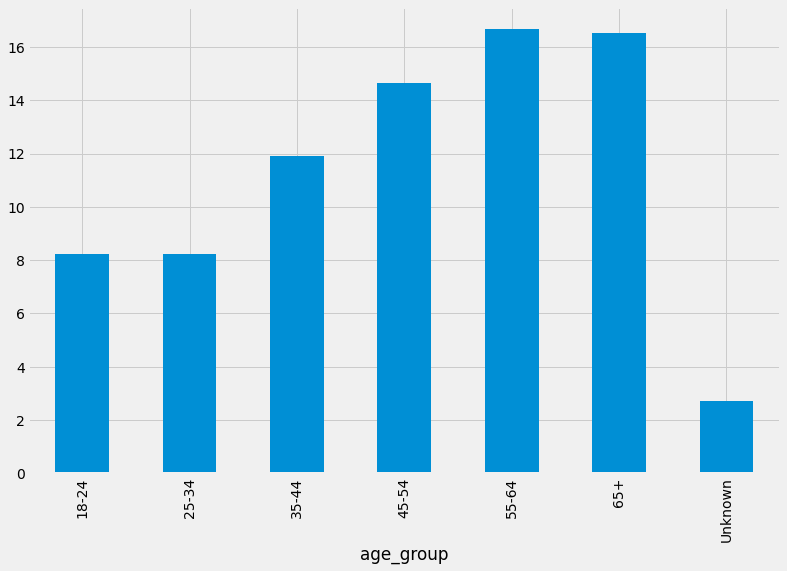

In [264]:
transactions.groupby(['age_group'])['transaction_amt'].mean().plot.bar(figsize=(12,8))

In [273]:
df.loc[df['person']== '1e9420836d554513ab90eba98552d0a9']

,person,event,time,age,became_member_on,income,transaction_amt,offer_id,reward_received,channels,difficulty,duration,email,mobile,social,web,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
19,1e9420836d554513ab90eba98552d0a9,offer received,0,22,2017-09-25,70000.0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,"[email, mobile, social]",10.0,7.0,1.0,1.0,1.0,0.0,0,1,0,1,0,0
40779,1e9420836d554513ab90eba98552d0a9,offer viewed,96,22,2017-09-25,70000.0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,"[email, mobile, social]",10.0,7.0,1.0,1.0,1.0,0.0,0,1,0,1,0,0
53196,1e9420836d554513ab90eba98552d0a9,offer received,168,22,2017-09-25,70000.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,"[web, email, mobile, social]",10.0,5.0,1.0,1.0,1.0,1.0,0,1,0,1,0,0
69328,1e9420836d554513ab90eba98552d0a9,offer viewed,174,22,2017-09-25,70000.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,"[web, email, mobile, social]",10.0,5.0,1.0,1.0,1.0,1.0,0,1,0,1,0,0
79426,1e9420836d554513ab90eba98552d0a9,transaction,198,22,2017-09-25,70000.0,17.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230416,1e9420836d554513ab90eba98552d0a9,offer viewed,534,22,2017-09-25,70000.0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,"[web, email, mobile]",0.0,4.0,1.0,1.0,0.0,1.0,0,1,0,0,0,1
245143,1e9420836d554513ab90eba98552d0a9,offer received,576,22,2017-09-25,70000.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,"[web, email]",20.0,10.0,1.0,0.0,0.0,1.0,0,1,0,0,1,0
257891,1e9420836d554513ab90eba98552d0a9,offer viewed,576,22,2017-09-25,70000.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,"[web, email]",20.0,10.0,1.0,0.0,0.0,1.0,0,1,0,0,1,0
271788,1e9420836d554513ab90eba98552d0a9,transaction,600,22,2017-09-25,70000.0,28.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0


In [199]:
df.rename(columns={'reward_x':'reward_received', 'offer_type_y':'offer_type'}, inplace=True)


### Objectives
1. Predict how much a user will spend based on demographics and offer type.
2. Determine which demographics we should send which offers to. 
3. Which types of channels are are most effective and lead to customer purchases

In [202]:
df = pd.get_dummies(df, columns=['gender', 'offer_type'])


In [205]:
df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')

determine if a transaction was made in the given duration


In [244]:
person_df = df.loc[df['person'] == '78afa995795e4d85b5d9ceeca43f5fef']
person_df.loc[(df['event'] == 'offer_viewed') | (df['event'] == 'offer_completed')]


,person,event,time,age,became_member_on,income,transaction_amt,offer_id,reward_received,channels,difficulty,duration,email,mobile,social,web,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational


In [ ]:
def influenced_by_offer(person, df=df):
    for person in df['person'].unique():
        person_df = df.loc[df['person'] == person]
        
        
    
    